Get best bin sizes from comparing to Travis ages, also adding columns in the end for errors

In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [2]:
df_prot_s=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')
df_rvar_s=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

df_prot_p=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin_pc.pkl')
df_rvar_p=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin_pc.pkl')


df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')

merg1=['KID','age','Rvar','Prot','teff_calc','Prot_log',
       'logg_y','v_b','w','abs_G','source_id','designation']
merg2=['KID','age','Rvar','teff_calc','Rvar_log','logg','v_b','abs_G','source_id']
df_prot_s=pd.merge(df_isoages,df_prot_s[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_s=pd.merge(df_isoages,df_rvar_s[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_s=df_prot_s.dropna(subset=['age','iso_age'])
df_rvar_s=df_rvar_s.dropna(subset=['age','iso_age'])

#df_prot_s=df_prot_s.loc[df_prot_s['iso_age']<10]
#df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]
#df_prot_s=df_prot_s.loc[abs(df_prot_s['iso_age_err2'])<3]
df_prot_s['iso_age_err']=np.sqrt(df_prot_s['iso_age_err1']**2.+df_prot_s['iso_age_err2']**2.)

df_prot_p=pd.merge(df_isoages,df_prot_p[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_p=pd.merge(df_isoages,df_rvar_p[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_p=df_prot_p.dropna(subset=['age','iso_age'])
df_rvar_p=df_rvar_p.dropna(subset=['age','iso_age'])


In [36]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            #mask = mask & (paras[:,j]>=checkpara[j]-binfs[j]/2)
            #mask = mask & (paras[:,j]<=checkpara[j]+binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)
    
import time
from tqdm import trange
# get average ages
def getkinAges_err(df,fs,binfs,sampsize=10):
    df=df.dropna(subset=['v_b'])
    bin_low=[i*0.5 for i in binfs]
    bin_hi=[i*1.5 for i in binfs]
    
    bins=np.zeros((len(binfs),sampsize))
    ages=np.zeros((len(df),sampsize))
    for i in range(len(binfs)):
        bins[i,:]=np.linspace(bin_low[i],bin_hi[i],sampsize)
    for i in range(sampsize):
        getkinAges(df,fs,bins[:,i])
        ages[:,i]=df['kin_age']
    getkinAges(df,fs,binfs)
    
    df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 
    return ages


    

In [13]:

    

getkinAges_err(df_prot_s,['teff_calc','Prot_log','abs_G','logg_y'],[366.6666666666667, 2.0, 0.01,0.5499999999999999])  


100%|██████████| 20714/20714 [00:05<00:00, 3543.77it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
100%|██████████| 20714/20714 [00:05<00:00, 3520.48it/s]


## real ages (real chisq)

In [10]:
# compare to real ages
import scipy

protbins=np.linspace(1.,5.,5)
loggbins=np.linspace(0.1,0.7,5)
tempbins=np.linspace(100.,500.,4)
absg=np.linspace(0.0001,0.05,5)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            for l in absg:
                print(float(count)/float(total))
                count=count+1
                getkinAges(df_prot_s,['teff_calc','Prot_log','logg_y','abs_G'],[i,j,k,l])
                stat_df=df_prot_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
                if len(stat_df)<1000:
                    continue
                stat_df=stat_df.loc[stat_df['iso_age']<10]
                stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
                chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
                chisq.append(chisq_sing/len(stat_df))
                MAD.append(np.median(stat_df['kin_age']-stat_df['iso_age']/
                                 np.sqrt(np.power(stat_df['kin_age'],2)+np.power(stat_df['iso_age'],2))))
                tempbins_a.append(i)
                protbins_a.append(j)
                loggbins_a.append(k)
                absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  1%|▏         | 270/20714 [00:00<00:07, 2696.63it/s]

0.002


100%|██████████| 20714/20714 [00:07<00:00, 2695.04it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  2%|▏         | 368/20714 [00:00<00:05, 3669.70it/s]

0.004


  3%|▎         | 710/20714 [00:00<00:05, 3551.28it/s]

0.006


  2%|▏         | 367/20714 [00:00<00:05, 3663.23it/s]

0.008


  2%|▏         | 363/20714 [00:00<00:05, 3621.15it/s]

0.01


  4%|▎         | 733/20714 [00:00<00:05, 3670.62it/s]

0.012


  2%|▏         | 354/20714 [00:00<00:05, 3532.87it/s]

0.014


  1%|          | 211/20714 [00:00<00:09, 2100.76it/s]

0.016


  1%|          | 215/20714 [00:00<00:09, 2144.49it/s]

0.018


  3%|▎         | 583/20714 [00:00<00:06, 2998.60it/s]

0.02


  1%|▏         | 293/20714 [00:00<00:06, 2922.49it/s]

0.022


  3%|▎         | 724/20714 [00:00<00:05, 3622.59it/s]

0.024


  2%|▏         | 363/20714 [00:00<00:05, 3628.18it/s]

0.026


  2%|▏         | 339/20714 [00:00<00:06, 3382.16it/s]

0.028


  1%|▏         | 263/20714 [00:00<00:07, 2625.00it/s]

0.03


  3%|▎         | 690/20714 [00:00<00:05, 3522.88it/s]

0.032


  2%|▏         | 347/20714 [00:00<00:05, 3463.32it/s]

0.034


  2%|▏         | 475/20714 [00:00<00:08, 2407.88it/s]

0.036


  1%|▏         | 281/20714 [00:00<00:07, 2804.87it/s]

0.038


  1%|          | 215/20714 [00:00<00:09, 2146.82it/s]

0.04


  1%|          | 257/20714 [00:00<00:07, 2565.65it/s]

0.042


  3%|▎         | 662/20714 [00:00<00:06, 3300.02it/s]

0.044


  2%|▏         | 318/20714 [00:00<00:06, 3167.17it/s]

0.046


  1%|▏         | 284/20714 [00:00<00:07, 2839.43it/s]

0.048


  3%|▎         | 537/20714 [00:00<00:07, 2696.52it/s]

0.05


  2%|▏         | 347/20714 [00:00<00:05, 3463.56it/s]

0.052


  1%|          | 222/20714 [00:00<00:09, 2217.34it/s]

0.054


  2%|▏         | 340/20714 [00:00<00:05, 3397.52it/s]

0.056


  1%|▏         | 286/20714 [00:00<00:07, 2855.60it/s]

0.058


  2%|▏         | 441/20714 [00:00<00:08, 2291.97it/s]

0.06


  2%|▏         | 320/20714 [00:00<00:06, 3195.82it/s]

0.062


  2%|▏         | 311/20714 [00:00<00:06, 3105.49it/s]

0.064


  1%|▏         | 277/20714 [00:00<00:07, 2764.92it/s]

0.066


  2%|▏         | 362/20714 [00:00<00:05, 3612.09it/s]

0.068


  3%|▎         | 707/20714 [00:00<00:05, 3557.35it/s]

0.07


  2%|▏         | 343/20714 [00:00<00:05, 3426.91it/s]

0.072


  2%|▏         | 369/20714 [00:00<00:05, 3688.71it/s]

0.074


  2%|▏         | 324/20714 [00:00<00:06, 3238.57it/s]

0.076


  1%|▏         | 273/20714 [00:00<00:07, 2728.47it/s]

0.078


  1%|▏         | 299/20714 [00:00<00:06, 2973.38it/s]

0.08


  2%|▏         | 346/20714 [00:00<00:05, 3456.99it/s]

0.082


  2%|▏         | 367/20714 [00:00<00:05, 3664.77it/s]

0.084


  1%|          | 227/20714 [00:00<00:09, 2266.28it/s]

0.086


  2%|▏         | 352/20714 [00:00<00:05, 3519.99it/s]

0.088


  2%|▏         | 320/20714 [00:00<00:06, 3192.38it/s]

0.09


  3%|▎         | 584/20714 [00:00<00:07, 2828.45it/s]

0.092


  2%|▏         | 353/20714 [00:00<00:05, 3524.72it/s]

0.094


  1%|          | 165/20714 [00:00<00:12, 1649.54it/s]

0.096


  2%|▏         | 347/20714 [00:00<00:05, 3469.10it/s]

0.098


  2%|▏         | 326/20714 [00:00<00:06, 3256.09it/s]

0.1


  1%|          | 195/20714 [00:00<00:10, 1946.35it/s]

0.102


  2%|▏         | 370/20714 [00:00<00:05, 3697.40it/s]

0.104


  3%|▎         | 570/20714 [00:00<00:07, 2770.91it/s]

0.106


  2%|▏         | 352/20714 [00:00<00:05, 3517.26it/s]

0.108


  3%|▎         | 712/20714 [00:00<00:05, 3580.23it/s]

0.11


  3%|▎         | 720/20714 [00:00<00:05, 3608.01it/s]

0.112


  1%|▏         | 297/20714 [00:00<00:06, 2966.69it/s]

0.114


  3%|▎         | 620/20714 [00:00<00:06, 3131.82it/s]

0.116


  3%|▎         | 671/20714 [00:00<00:06, 3331.82it/s]

0.118


  1%|▏         | 270/20714 [00:00<00:07, 2698.00it/s]

0.12


  1%|▏         | 303/20714 [00:00<00:06, 2998.66it/s]

0.122


  2%|▏         | 354/20714 [00:00<00:05, 3537.73it/s]

0.124


  2%|▏         | 350/20714 [00:00<00:05, 3497.24it/s]

0.126


  2%|▏         | 338/20714 [00:00<00:06, 3377.60it/s]

0.128


  2%|▏         | 329/20714 [00:00<00:06, 3264.41it/s]

0.13


  2%|▏         | 317/20714 [00:00<00:06, 3163.08it/s]

0.132


  2%|▏         | 366/20714 [00:00<00:05, 3653.52it/s]

0.134


  3%|▎         | 676/20714 [00:00<00:05, 3466.54it/s]

0.136


  1%|▏         | 273/20714 [00:00<00:07, 2725.62it/s]

0.138


  1%|          | 252/20714 [00:00<00:08, 2513.39it/s]

0.14


  2%|▏         | 324/20714 [00:00<00:06, 3237.19it/s]

0.142


  2%|▏         | 330/20714 [00:00<00:06, 3297.39it/s]

0.144


  1%|          | 215/20714 [00:00<00:09, 2146.35it/s]

0.146


  3%|▎         | 637/20714 [00:00<00:06, 3163.25it/s]

0.148


  2%|▏         | 316/20714 [00:00<00:06, 3157.82it/s]

0.15


  1%|▏         | 305/20714 [00:00<00:06, 3048.96it/s]

0.152


  2%|▏         | 325/20714 [00:00<00:06, 3245.72it/s]

0.154


  2%|▏         | 335/20714 [00:00<00:06, 3349.91it/s]

0.156


  2%|▏         | 315/20714 [00:00<00:06, 3141.51it/s]

0.158


  2%|▏         | 323/20714 [00:00<00:06, 3229.97it/s]

0.16


  3%|▎         | 651/20714 [00:00<00:06, 3230.54it/s]

0.162


  3%|▎         | 653/20714 [00:00<00:06, 3264.28it/s]

0.164


  2%|▏         | 318/20714 [00:00<00:06, 3178.40it/s]

0.166


  3%|▎         | 652/20714 [00:00<00:06, 3265.42it/s]

0.168


  2%|▏         | 319/20714 [00:00<00:06, 3184.77it/s]

0.17


  1%|▏         | 297/20714 [00:00<00:06, 2962.87it/s]

0.172


  2%|▏         | 331/20714 [00:00<00:06, 3306.95it/s]

0.174


  1%|          | 239/20714 [00:00<00:08, 2386.75it/s]

0.176


  1%|          | 253/20714 [00:00<00:08, 2528.22it/s]

0.178


  3%|▎         | 614/20714 [00:00<00:06, 3117.03it/s]

0.18


  1%|▏         | 268/20714 [00:00<00:07, 2672.73it/s]

0.182


  3%|▎         | 643/20714 [00:00<00:06, 3193.33it/s]

0.184


  3%|▎         | 655/20714 [00:00<00:06, 3273.50it/s]

0.186


  2%|▏         | 328/20714 [00:00<00:06, 3271.00it/s]

0.188


  3%|▎         | 646/20714 [00:00<00:06, 3239.24it/s]

0.19


  2%|▏         | 315/20714 [00:00<00:06, 3141.84it/s]

0.192


  3%|▎         | 638/20714 [00:00<00:06, 3144.25it/s]

0.194


  3%|▎         | 640/20714 [00:00<00:06, 3194.26it/s]

0.196


  2%|▏         | 325/20714 [00:00<00:06, 3240.47it/s]

0.198


  2%|▏         | 311/20714 [00:00<00:06, 3108.45it/s]

0.2


  2%|▏         | 324/20714 [00:00<00:06, 3231.63it/s]

0.202


  2%|▏         | 336/20714 [00:00<00:06, 3350.88it/s]

0.204


  3%|▎         | 627/20714 [00:00<00:06, 3185.51it/s]

0.206


  3%|▎         | 653/20714 [00:00<00:06, 3264.05it/s]

0.208


  2%|▏         | 324/20714 [00:00<00:06, 3239.19it/s]

0.21


  2%|▏         | 323/20714 [00:00<00:06, 3229.39it/s]

0.212


  2%|▏         | 321/20714 [00:00<00:06, 3202.15it/s]

0.214


  3%|▎         | 632/20714 [00:00<00:06, 3148.37it/s]

0.216


  1%|▏         | 291/20714 [00:00<00:07, 2899.39it/s]

0.218


  3%|▎         | 644/20714 [00:00<00:06, 3209.68it/s]

0.22


  1%|          | 154/20714 [00:00<00:13, 1527.82it/s]

0.222


  1%|▏         | 272/20714 [00:00<00:07, 2717.37it/s]

0.224


  3%|▎         | 663/20714 [00:00<00:06, 3319.48it/s]

0.226


  3%|▎         | 658/20714 [00:00<00:06, 3291.70it/s]

0.228


  1%|▏         | 296/20714 [00:00<00:06, 2957.25it/s]

0.23


  1%|▏         | 307/20714 [00:00<00:06, 3068.84it/s]

0.232


  1%|▏         | 282/20714 [00:00<00:07, 2817.86it/s]

0.234


  2%|▏         | 484/20714 [00:00<00:08, 2430.86it/s]

0.236


  1%|▏         | 291/20714 [00:00<00:07, 2906.14it/s]

0.238


  2%|▏         | 332/20714 [00:00<00:06, 3313.27it/s]

0.24


  1%|          | 226/20714 [00:00<00:09, 2254.65it/s]

0.242


  1%|          | 173/20714 [00:00<00:11, 1721.17it/s]

0.244


  2%|▏         | 382/20714 [00:00<00:10, 1913.28it/s]

0.246


  1%|          | 188/20714 [00:00<00:10, 1875.13it/s]

0.248


  1%|          | 165/20714 [00:00<00:12, 1646.48it/s]

0.25


  1%|          | 202/20714 [00:00<00:10, 2013.40it/s]

0.252


  2%|▏         | 428/20714 [00:00<00:09, 2165.71it/s]

0.254


  1%|          | 178/20714 [00:00<00:11, 1776.99it/s]

0.256


  2%|▏         | 475/20714 [00:00<00:08, 2407.56it/s]

0.258


  1%|          | 209/20714 [00:00<00:09, 2088.85it/s]

0.26


  1%|          | 205/20714 [00:00<00:10, 2044.64it/s]

0.262


  2%|▏         | 312/20714 [00:00<00:06, 3119.02it/s]

0.264


  2%|▏         | 318/20714 [00:00<00:06, 3170.86it/s]

0.266


  1%|          | 197/20714 [00:00<00:10, 1969.39it/s]

0.268


  3%|▎         | 629/20714 [00:00<00:06, 3144.71it/s]

0.27


  1%|▏         | 276/20714 [00:00<00:15, 1288.70it/s]

0.272


  2%|▏         | 437/20714 [00:00<00:09, 2094.65it/s]

0.274


  1%|▏         | 298/20714 [00:00<00:06, 2978.45it/s]

0.276


  1%|          | 247/20714 [00:00<00:08, 2469.80it/s]

0.278


  1%|          | 191/20714 [00:00<00:10, 1903.22it/s]

0.28


  1%|▏         | 293/20714 [00:00<00:06, 2926.69it/s]

0.282


  3%|▎         | 649/20714 [00:00<00:06, 3243.54it/s]

0.284


  3%|▎         | 608/20714 [00:00<00:06, 3088.99it/s]

0.286


  1%|▏         | 305/20714 [00:00<00:13, 1492.33it/s]

0.288


  1%|          | 114/20714 [00:00<00:18, 1138.44it/s]

0.29


  1%|▏         | 275/20714 [00:00<00:07, 2749.03it/s]

0.292


  1%|          | 182/20714 [00:00<00:11, 1815.97it/s]

0.294


  1%|▏         | 303/20714 [00:00<00:06, 3025.85it/s]

0.296


  1%|          | 196/20714 [00:00<00:10, 1957.73it/s]

0.298


  1%|▏         | 265/20714 [00:00<00:07, 2634.06it/s]

0.3


  2%|▏         | 311/20714 [00:00<00:06, 3108.51it/s]

0.302


  3%|▎         | 565/20714 [00:00<00:07, 2644.27it/s]

0.304


  3%|▎         | 572/20714 [00:00<00:06, 2928.77it/s]

0.306


  1%|▏         | 305/20714 [00:00<00:06, 3049.25it/s]

0.308


  1%|          | 173/20714 [00:00<00:11, 1726.17it/s]

0.31


  1%|          | 135/20714 [00:00<00:15, 1344.32it/s]

0.312


  2%|▏         | 331/20714 [00:00<00:06, 3304.58it/s]

0.314


  1%|          | 148/20714 [00:00<00:13, 1474.59it/s]

0.316


  1%|▏         | 306/20714 [00:00<00:06, 3058.62it/s]

0.318


  1%|          | 169/20714 [00:00<00:12, 1684.88it/s]

0.32


  1%|          | 157/20714 [00:00<00:13, 1547.30it/s]

0.322


  1%|          | 151/20714 [00:00<00:13, 1498.78it/s]

0.324


  1%|          | 241/20714 [00:00<00:08, 2409.67it/s]

0.326


  1%|          | 151/20714 [00:00<00:13, 1508.13it/s]

0.328


  2%|▏         | 502/20714 [00:00<00:08, 2469.34it/s]

0.33


  1%|▏         | 301/20714 [00:00<00:06, 3007.98it/s]

0.332


  2%|▏         | 517/20714 [00:00<00:08, 2377.18it/s]

0.334


  3%|▎         | 617/20714 [00:00<00:06, 3071.33it/s]

0.336


  3%|▎         | 553/20714 [00:00<00:07, 2702.78it/s]

0.338


  1%|          | 233/20714 [00:00<00:08, 2323.91it/s]

0.34


  1%|▏         | 282/20714 [00:00<00:07, 2814.06it/s]

0.342


  1%|          | 235/20714 [00:00<00:08, 2346.92it/s]

0.344


  1%|          | 143/20714 [00:00<00:14, 1422.66it/s]

0.346


  1%|          | 216/20714 [00:00<00:09, 2134.05it/s]

0.348


  1%|▏         | 302/20714 [00:00<00:06, 3016.71it/s]

0.35


  1%|▏         | 308/20714 [00:00<00:06, 3078.09it/s]

0.352


  1%|▏         | 307/20714 [00:00<00:06, 3068.93it/s]

0.354


  1%|          | 228/20714 [00:00<00:09, 2270.22it/s]

0.356


  3%|▎         | 552/20714 [00:00<00:07, 2776.23it/s]

0.358


  1%|▏         | 300/20714 [00:00<00:06, 2986.23it/s]

0.36


  1%|          | 220/20714 [00:00<00:09, 2194.58it/s]

0.362


  1%|▏         | 287/20714 [00:00<00:07, 2798.37it/s]

0.364


  3%|▎         | 527/20714 [00:00<00:07, 2619.32it/s]

0.366


  3%|▎         | 629/20714 [00:00<00:06, 3129.76it/s]

0.368


  1%|▏         | 297/20714 [00:00<00:06, 2966.23it/s]

0.37


  1%|▏         | 271/20714 [00:00<00:07, 2702.93it/s]

0.372


  3%|▎         | 661/20714 [00:00<00:06, 3311.72it/s]

0.374


  2%|▏         | 327/20714 [00:00<00:06, 3262.47it/s]

0.376


  1%|▏         | 309/20714 [00:00<00:06, 3081.93it/s]

0.378


  1%|          | 120/20714 [00:00<00:17, 1196.70it/s]

0.38


  2%|▏         | 323/20714 [00:00<00:06, 3225.22it/s]

0.382


  2%|▏         | 319/20714 [00:00<00:06, 3182.40it/s]

0.384


  1%|▏         | 305/20714 [00:00<00:06, 3041.24it/s]

0.386


  3%|▎         | 615/20714 [00:00<00:06, 3098.15it/s]

0.388


  1%|▏         | 287/20714 [00:00<00:07, 2868.00it/s]

0.39


  2%|▏         | 325/20714 [00:00<00:06, 3248.96it/s]

0.392


  2%|▏         | 325/20714 [00:00<00:06, 3244.49it/s]

0.394


  2%|▏         | 496/20714 [00:00<00:07, 2583.07it/s]

0.396


  1%|▏         | 270/20714 [00:00<00:07, 2695.04it/s]

0.398


  1%|▏         | 296/20714 [00:00<00:06, 2957.66it/s]

0.4


  2%|▏         | 324/20714 [00:00<00:06, 3237.57it/s]

0.402


  1%|          | 107/20714 [00:00<00:19, 1067.03it/s]

0.404


  1%|          | 220/20714 [00:00<00:09, 2189.36it/s]

0.406


  1%|          | 247/20714 [00:00<00:08, 2467.21it/s]

0.408


  1%|          | 248/20714 [00:00<00:08, 2479.16it/s]

0.41


  1%|▏         | 280/20714 [00:00<00:07, 2796.70it/s]

0.412


  2%|▏         | 320/20714 [00:00<00:06, 3195.61it/s]

0.414


  1%|▏         | 273/20714 [00:00<00:07, 2727.49it/s]

0.416


  1%|          | 252/20714 [00:00<00:08, 2512.87it/s]

0.418


  3%|▎         | 600/20714 [00:00<00:06, 2969.75it/s]

0.42


  1%|▏         | 265/20714 [00:00<00:07, 2644.76it/s]

0.422


  1%|          | 214/20714 [00:00<00:09, 2135.98it/s]

0.424


  3%|▎         | 630/20714 [00:00<00:06, 3152.08it/s]

0.426


  2%|▏         | 314/20714 [00:00<00:06, 3132.86it/s]

0.428


  1%|▏         | 272/20714 [00:00<00:07, 2711.40it/s]

0.43


  2%|▏         | 318/20714 [00:00<00:06, 3178.34it/s]

0.432


  3%|▎         | 641/20714 [00:00<00:06, 3181.08it/s]

0.434


  1%|          | 255/20714 [00:00<00:08, 2548.27it/s]

0.436


  2%|▏         | 320/20714 [00:00<00:06, 3199.93it/s]

0.438


  3%|▎         | 615/20714 [00:00<00:06, 3054.39it/s]

0.44


  2%|▏         | 325/20714 [00:00<00:06, 3245.14it/s]

0.442


  2%|▏         | 317/20714 [00:00<00:06, 3167.81it/s]

0.444


  1%|          | 245/20714 [00:00<00:08, 2444.48it/s]

0.446


  2%|▏         | 317/20714 [00:00<00:06, 3165.57it/s]

0.448


  1%|          | 242/20714 [00:00<00:08, 2415.79it/s]

0.45


  2%|▏         | 334/20714 [00:00<00:06, 3337.83it/s]

0.452


  3%|▎         | 600/20714 [00:00<00:07, 2865.62it/s]

0.454


  2%|▏         | 320/20714 [00:00<00:06, 3191.88it/s]

0.456


  3%|▎         | 621/20714 [00:00<00:06, 3052.56it/s]

0.458


  3%|▎         | 572/20714 [00:00<00:07, 2875.07it/s]

0.46


  2%|▏         | 327/20714 [00:00<00:06, 3267.68it/s]

0.462


  2%|▏         | 312/20714 [00:00<00:06, 3111.42it/s]

0.464


  3%|▎         | 559/20714 [00:00<00:07, 2682.24it/s]

0.466


  1%|          | 172/20714 [00:00<00:11, 1714.02it/s]

0.468


  2%|▏         | 314/20714 [00:00<00:06, 3133.82it/s]

0.47


  3%|▎         | 620/20714 [00:00<00:06, 3124.42it/s]

0.472


  1%|▏         | 293/20714 [00:00<00:06, 2922.00it/s]

0.474


  2%|▏         | 323/20714 [00:00<00:06, 3210.38it/s]

0.476


  1%|▏         | 304/20714 [00:00<00:06, 3034.41it/s]

0.478


  1%|▏         | 278/20714 [00:00<00:07, 2777.42it/s]

0.48


  2%|▏         | 330/20714 [00:00<00:06, 3294.60it/s]

0.482


  2%|▏         | 311/20714 [00:00<00:06, 3107.20it/s]

0.484


  1%|▏         | 299/20714 [00:00<00:06, 2987.34it/s]

0.486


  2%|▏         | 314/20714 [00:00<00:06, 3134.83it/s]

0.488


  3%|▎         | 614/20714 [00:00<00:06, 3070.63it/s]

0.49


  2%|▏         | 326/20714 [00:00<00:06, 3254.21it/s]

0.492


  2%|▏         | 315/20714 [00:00<00:06, 3148.52it/s]

0.494


  2%|▏         | 319/20714 [00:00<00:06, 3187.64it/s]

0.496


  2%|▏         | 315/20714 [00:00<00:06, 3140.61it/s]

0.498


  3%|▎         | 615/20714 [00:00<00:06, 3082.35it/s]

0.5


  1%|▏         | 302/20714 [00:00<00:06, 3014.25it/s]

0.502


  2%|▏         | 313/20714 [00:00<00:06, 3129.13it/s]

0.504


  2%|▏         | 324/20714 [00:00<00:06, 3234.41it/s]

0.506


  2%|▏         | 315/20714 [00:00<00:06, 3146.39it/s]

0.508


  1%|▏         | 305/20714 [00:00<00:06, 3043.34it/s]

0.51


  2%|▏         | 336/20714 [00:00<00:06, 3351.02it/s]

0.512


  1%|          | 246/20714 [00:00<00:08, 2456.21it/s]

0.514


  1%|▏         | 302/20714 [00:00<00:06, 3016.74it/s]

0.516


  1%|▏         | 300/20714 [00:00<00:06, 2998.10it/s]

0.518


  3%|▎         | 550/20714 [00:00<00:07, 2649.94it/s]

0.52


  2%|▏         | 329/20714 [00:00<00:06, 3285.47it/s]

0.522


  3%|▎         | 614/20714 [00:00<00:06, 3063.87it/s]

0.524


  1%|▏         | 307/20714 [00:00<00:06, 3067.91it/s]

0.526


  1%|▏         | 310/20714 [00:00<00:06, 3098.83it/s]

0.528


  1%|▏         | 306/20714 [00:00<00:06, 3059.67it/s]

0.53


  3%|▎         | 618/20714 [00:00<00:06, 3119.75it/s]

0.532


  2%|▏         | 320/20714 [00:00<00:06, 3198.62it/s]

0.534


  3%|▎         | 612/20714 [00:00<00:06, 3034.79it/s]

0.536


  1%|▏         | 278/20714 [00:00<00:07, 2765.62it/s]

0.538


  1%|▏         | 292/20714 [00:00<00:07, 2915.39it/s]

0.54


  2%|▏         | 326/20714 [00:00<00:06, 3253.69it/s]

0.542


  3%|▎         | 626/20714 [00:00<00:06, 3164.94it/s]

0.544


  2%|▏         | 315/20714 [00:00<00:06, 3147.02it/s]

0.546


  3%|▎         | 615/20714 [00:00<00:06, 3077.54it/s]

0.548


  3%|▎         | 607/20714 [00:00<00:06, 3052.14it/s]

0.55


  1%|▏         | 309/20714 [00:00<00:06, 3082.45it/s]

0.552


  2%|▏         | 334/20714 [00:00<00:06, 3335.70it/s]

0.554


  2%|▏         | 321/20714 [00:00<00:06, 3205.89it/s]

0.556


  2%|▏         | 313/20714 [00:00<00:06, 3122.42it/s]

0.558


  2%|▏         | 316/20714 [00:00<00:06, 3154.01it/s]

0.56


  2%|▏         | 330/20714 [00:00<00:06, 3298.25it/s]

0.562


  1%|▏         | 305/20714 [00:00<00:06, 3045.22it/s]

0.564


  1%|▏         | 304/20714 [00:00<00:06, 3034.81it/s]

0.566


  2%|▏         | 312/20714 [00:00<00:06, 3117.63it/s]

0.568


  3%|▎         | 610/20714 [00:00<00:06, 3053.23it/s]

0.57


  2%|▏         | 334/20714 [00:00<00:06, 3333.40it/s]

0.572


  1%|▏         | 287/20714 [00:00<00:07, 2862.30it/s]

0.574


  3%|▎         | 617/20714 [00:00<00:06, 3060.15it/s]

0.576


  3%|▎         | 601/20714 [00:00<00:06, 2995.84it/s]

0.578


  3%|▎         | 598/20714 [00:00<00:06, 2992.51it/s]

0.58


  2%|▏         | 316/20714 [00:00<00:06, 3156.97it/s]

0.582


  3%|▎         | 635/20714 [00:00<00:06, 3176.27it/s]

0.584


  1%|▏         | 303/20714 [00:00<00:06, 3024.68it/s]

0.586


  1%|▏         | 307/20714 [00:00<00:06, 3066.44it/s]

0.588


  1%|          | 246/20714 [00:00<00:08, 2457.37it/s]

0.59


  2%|▏         | 325/20714 [00:00<00:06, 3242.97it/s]

0.592


  2%|▏         | 317/20714 [00:00<00:06, 3168.29it/s]

0.594


  3%|▎         | 590/20714 [00:00<00:06, 2984.68it/s]

0.596


  3%|▎         | 594/20714 [00:00<00:06, 2951.00it/s]

0.598


  3%|▎         | 595/20714 [00:00<00:06, 2973.24it/s]

0.6


  3%|▎         | 650/20714 [00:00<00:06, 3272.18it/s]

0.602


  2%|▏         | 324/20714 [00:00<00:06, 3231.57it/s]

0.604


  2%|▏         | 324/20714 [00:00<00:06, 3232.67it/s]

0.606


  2%|▏         | 317/20714 [00:00<00:06, 3160.86it/s]

0.608


  3%|▎         | 612/20714 [00:00<00:06, 3005.22it/s]

0.61


  2%|▏         | 326/20714 [00:00<00:06, 3252.20it/s]

0.612


  3%|▎         | 631/20714 [00:00<00:06, 3167.96it/s]

0.614


  3%|▎         | 623/20714 [00:00<00:06, 3115.09it/s]

0.616


  1%|▏         | 308/20714 [00:00<00:06, 3071.25it/s]

0.618


  1%|▏         | 305/20714 [00:00<00:06, 3041.84it/s]

0.62


  2%|▏         | 319/20714 [00:00<00:06, 3184.27it/s]

0.622


  3%|▎         | 632/20714 [00:00<00:06, 3157.61it/s]

0.624


  3%|▎         | 601/20714 [00:00<00:06, 2983.84it/s]

0.626


  1%|▏         | 310/20714 [00:00<00:06, 3090.66it/s]

0.628


  3%|▎         | 599/20714 [00:00<00:06, 2981.59it/s]

0.63


  3%|▎         | 651/20714 [00:00<00:06, 3255.93it/s]

0.632


  2%|▏         | 321/20714 [00:00<00:06, 3208.11it/s]

0.634


  3%|▎         | 590/20714 [00:00<00:06, 2921.97it/s]

0.636


  3%|▎         | 573/20714 [00:00<00:07, 2784.64it/s]

0.638


  1%|▏         | 301/20714 [00:00<00:06, 3004.59it/s]

0.64


  1%|▏         | 305/20714 [00:00<00:06, 3042.73it/s]

0.642


  3%|▎         | 551/20714 [00:00<00:07, 2747.43it/s]

0.644


  3%|▎         | 617/20714 [00:00<00:06, 3073.64it/s]

0.646


  1%|          | 249/20714 [00:00<00:08, 2485.23it/s]

0.648


  1%|▏         | 289/20714 [00:00<00:07, 2882.36it/s]

0.65


  2%|▏         | 322/20714 [00:00<00:06, 3218.58it/s]

0.652


  2%|▏         | 329/20714 [00:00<00:06, 3282.65it/s]

0.654


  3%|▎         | 640/20714 [00:00<00:06, 3205.36it/s]

0.656


  3%|▎         | 605/20714 [00:00<00:06, 3064.71it/s]

0.658


  2%|▏         | 317/20714 [00:00<00:06, 3167.40it/s]

0.66


  3%|▎         | 644/20714 [00:00<00:06, 3216.77it/s]

0.662


  2%|▏         | 320/20714 [00:00<00:06, 3192.21it/s]

0.664


  1%|▏         | 297/20714 [00:00<00:06, 2965.11it/s]

0.666


  3%|▎         | 589/20714 [00:00<00:06, 2948.22it/s]

0.668


  1%|▏         | 266/20714 [00:00<00:07, 2657.58it/s]

0.67


  2%|▏         | 326/20714 [00:00<00:06, 3259.37it/s]

0.672


  3%|▎         | 602/20714 [00:00<00:06, 2965.15it/s]

0.674


  3%|▎         | 620/20714 [00:00<00:06, 3099.03it/s]

0.676


  3%|▎         | 574/20714 [00:00<00:07, 2875.67it/s]

0.678


  3%|▎         | 590/20714 [00:00<00:06, 2957.66it/s]

0.68


  3%|▎         | 635/20714 [00:00<00:06, 3195.85it/s]

0.682


  2%|▏         | 314/20714 [00:00<00:06, 3131.16it/s]

0.684


  1%|▏         | 308/20714 [00:00<00:06, 3075.32it/s]

0.686


  1%|          | 255/20714 [00:00<00:08, 2545.90it/s]

0.688


  3%|▎         | 563/20714 [00:00<00:07, 2804.31it/s]

0.69


  3%|▎         | 637/20714 [00:00<00:06, 3158.75it/s]

0.692


  3%|▎         | 544/20714 [00:00<00:07, 2739.00it/s]

0.694


  3%|▎         | 616/20714 [00:00<00:06, 3076.95it/s]

0.696


  1%|          | 196/20714 [00:00<00:10, 1958.73it/s]

0.698


  1%|▏         | 304/20714 [00:00<00:06, 3033.33it/s]

0.7


  2%|▏         | 329/20714 [00:00<00:06, 3283.04it/s]

0.702


  2%|▏         | 329/20714 [00:00<00:06, 3285.37it/s]

0.704


  3%|▎         | 616/20714 [00:00<00:06, 3059.37it/s]

0.706


  3%|▎         | 618/20714 [00:00<00:06, 3124.93it/s]

0.708


  2%|▏         | 319/20714 [00:00<00:06, 3186.09it/s]

0.71


  3%|▎         | 553/20714 [00:00<00:07, 2538.23it/s]

0.712


  3%|▎         | 592/20714 [00:00<00:06, 2968.10it/s]

0.714


  2%|▏         | 318/20714 [00:00<00:06, 3176.22it/s]

0.716


  3%|▎         | 617/20714 [00:00<00:06, 3084.38it/s]

0.718


  1%|▏         | 296/20714 [00:00<00:06, 2955.92it/s]

0.72


  2%|▏         | 322/20714 [00:00<00:06, 3211.88it/s]

0.722


  2%|▏         | 321/20714 [00:00<00:06, 3204.14it/s]

0.724


  3%|▎         | 597/20714 [00:00<00:06, 3011.80it/s]

0.726


  3%|▎         | 601/20714 [00:00<00:06, 3030.70it/s]

0.728


  1%|▏         | 295/20714 [00:00<00:06, 2946.55it/s]

0.73


  2%|▏         | 325/20714 [00:00<00:06, 3241.28it/s]

0.732


  1%|▏         | 267/20714 [00:00<00:07, 2662.63it/s]

0.734


  3%|▎         | 578/20714 [00:00<00:06, 2877.24it/s]

0.736


  3%|▎         | 612/20714 [00:00<00:06, 3059.22it/s]

0.738


  3%|▎         | 602/20714 [00:00<00:06, 3025.46it/s]

0.74


  2%|▏         | 323/20714 [00:00<00:06, 3223.51it/s]

0.742


  2%|▏         | 319/20714 [00:00<00:06, 3185.86it/s]

0.744


  1%|▏         | 308/20714 [00:00<00:06, 3072.81it/s]

0.746


  1%|▏         | 306/20714 [00:00<00:06, 3055.56it/s]

0.748


  1%|▏         | 302/20714 [00:00<00:06, 3017.50it/s]

0.75


  3%|▎         | 640/20714 [00:00<00:06, 3160.24it/s]

0.752


  3%|▎         | 643/20714 [00:00<00:06, 3210.13it/s]

0.754


  3%|▎         | 615/20714 [00:00<00:06, 3076.18it/s]

0.756


  3%|▎         | 634/20714 [00:00<00:06, 3171.37it/s]

0.758


  1%|▏         | 309/20714 [00:00<00:06, 3088.94it/s]

0.76


  2%|▏         | 328/20714 [00:00<00:06, 3278.23it/s]

0.762


  2%|▏         | 313/20714 [00:00<00:06, 3126.19it/s]

0.764


  1%|▏         | 308/20714 [00:00<00:06, 3074.62it/s]

0.766


  3%|▎         | 585/20714 [00:00<00:06, 2907.64it/s]

0.768


  1%|▏         | 283/20714 [00:00<00:07, 2823.64it/s]

0.77


  1%|▏         | 306/20714 [00:00<00:06, 3059.42it/s]

0.772


  3%|▎         | 617/20714 [00:00<00:06, 3074.47it/s]

0.774


  3%|▎         | 596/20714 [00:00<00:06, 2955.99it/s]

0.776


  3%|▎         | 604/20714 [00:00<00:06, 3024.80it/s]

0.778


  1%|▏         | 309/20714 [00:00<00:06, 3085.52it/s]

0.78


  3%|▎         | 642/20714 [00:00<00:06, 3231.71it/s]

0.782


  1%|▏         | 299/20714 [00:00<00:06, 2983.44it/s]

0.784


  3%|▎         | 550/20714 [00:00<00:07, 2757.46it/s]

0.786


  3%|▎         | 599/20714 [00:00<00:06, 2990.52it/s]

0.788


  3%|▎         | 574/20714 [00:00<00:06, 2895.08it/s]

0.79


  1%|▏         | 292/20714 [00:00<00:07, 2914.11it/s]

0.792


  2%|▏         | 317/20714 [00:00<00:06, 3163.26it/s]

0.794


  1%|▏         | 306/20714 [00:00<00:06, 3055.30it/s]

0.796


  3%|▎         | 600/20714 [00:00<00:06, 2990.89it/s]

0.798


  3%|▎         | 589/20714 [00:00<00:06, 2952.84it/s]

0.8


  2%|▏         | 319/20714 [00:00<00:06, 3183.54it/s]

0.802


  2%|▏         | 327/20714 [00:00<00:06, 3266.37it/s]

0.804


  1%|          | 246/20714 [00:00<00:08, 2453.01it/s]

0.806


  2%|▏         | 314/20714 [00:00<00:06, 3138.24it/s]

0.808


  2%|▏         | 313/20714 [00:00<00:06, 3123.66it/s]

0.81


  2%|▏         | 316/20714 [00:00<00:06, 3158.29it/s]

0.812


  1%|▏         | 307/20714 [00:00<00:06, 3062.56it/s]

0.814


  3%|▎         | 614/20714 [00:00<00:06, 3097.28it/s]

0.816


  3%|▎         | 602/20714 [00:00<00:06, 3002.67it/s]

0.818


  3%|▎         | 576/20714 [00:00<00:07, 2861.09it/s]

0.82


  3%|▎         | 649/20714 [00:00<00:06, 3240.82it/s]

0.822


  3%|▎         | 592/20714 [00:00<00:06, 2926.74it/s]

0.824


  1%|▏         | 307/20714 [00:00<00:06, 3062.53it/s]

0.826


  1%|▏         | 303/20714 [00:00<00:06, 3021.44it/s]

0.828


  3%|▎         | 601/20714 [00:00<00:06, 3006.80it/s]

0.83


  2%|▏         | 314/20714 [00:00<00:06, 3134.14it/s]

0.832


  2%|▏         | 311/20714 [00:00<00:06, 3107.67it/s]

0.834


  1%|          | 217/20714 [00:00<00:09, 2159.03it/s]

0.836


  2%|▏         | 399/20714 [00:00<00:10, 1952.17it/s]

0.838


  1%|          | 227/20714 [00:00<00:09, 2261.88it/s]

0.84


  3%|▎         | 645/20714 [00:00<00:06, 3223.63it/s]

0.842


  3%|▎         | 596/20714 [00:00<00:06, 2946.62it/s]

0.844


  1%|▏         | 295/20714 [00:00<00:06, 2945.96it/s]

0.846


  3%|▎         | 576/20714 [00:00<00:07, 2860.83it/s]

0.848


  1%|▏         | 283/20714 [00:00<00:07, 2825.79it/s]

0.85


  2%|▏         | 326/20714 [00:00<00:06, 3259.72it/s]

0.852


  3%|▎         | 619/20714 [00:00<00:06, 3081.04it/s]

0.854


  2%|▏         | 326/20714 [00:00<00:06, 3252.97it/s]

0.856


  3%|▎         | 590/20714 [00:00<00:06, 3004.22it/s]

0.858


  1%|▏         | 286/20714 [00:00<00:07, 2856.49it/s]

0.86


  3%|▎         | 537/20714 [00:00<00:08, 2462.51it/s]

0.862


  3%|▎         | 588/20714 [00:00<00:06, 2971.84it/s]

0.864


  2%|▏         | 314/20714 [00:00<00:06, 3131.98it/s]

0.866


  3%|▎         | 595/20714 [00:00<00:06, 2972.07it/s]

0.868


  1%|▏         | 295/20714 [00:00<00:06, 2949.62it/s]

0.87


  3%|▎         | 634/20714 [00:00<00:06, 3160.64it/s]

0.872


  1%|▏         | 270/20714 [00:00<00:07, 2697.74it/s]

0.874


  3%|▎         | 588/20714 [00:00<00:06, 2917.55it/s]

0.876


  3%|▎         | 594/20714 [00:00<00:06, 2960.44it/s]

0.878


  3%|▎         | 580/20714 [00:00<00:07, 2872.36it/s]

0.88


  1%|▏         | 293/20714 [00:00<00:06, 2925.58it/s]

0.882


  3%|▎         | 548/20714 [00:00<00:07, 2720.82it/s]

0.884


  3%|▎         | 528/20714 [00:00<00:07, 2615.07it/s]

0.886


  3%|▎         | 612/20714 [00:00<00:06, 3067.54it/s]

0.888


  2%|▏         | 502/20714 [00:00<00:08, 2469.74it/s]

0.89


  2%|▏         | 329/20714 [00:00<00:06, 3282.62it/s]

0.892


  3%|▎         | 624/20714 [00:00<00:06, 3090.35it/s]

0.894


  2%|▏         | 316/20714 [00:00<00:06, 3150.52it/s]

0.896


  2%|▏         | 311/20714 [00:00<00:06, 3109.22it/s]

0.898


  3%|▎         | 590/20714 [00:00<00:06, 2970.05it/s]

0.9


  3%|▎         | 650/20714 [00:00<00:06, 3222.41it/s]

0.902


  1%|▏         | 288/20714 [00:00<00:07, 2876.66it/s]

0.904


  2%|▏         | 319/20714 [00:00<00:06, 3185.19it/s]

0.906


  2%|▏         | 317/20714 [00:00<00:06, 3169.66it/s]

0.908


  3%|▎         | 617/20714 [00:00<00:06, 3112.05it/s]

0.91


  2%|▏         | 328/20714 [00:00<00:06, 3271.14it/s]

0.912


  1%|▏         | 302/20714 [00:00<00:06, 3016.47it/s]

0.914


  3%|▎         | 608/20714 [00:00<00:06, 3064.81it/s]

0.916


  3%|▎         | 591/20714 [00:00<00:06, 2958.31it/s]

0.918


  1%|▏         | 295/20714 [00:00<00:06, 2944.67it/s]

0.92


  3%|▎         | 624/20714 [00:00<00:06, 3147.48it/s]

0.922


  3%|▎         | 620/20714 [00:00<00:06, 3081.32it/s]

0.924


  1%|▏         | 296/20714 [00:00<00:06, 2951.94it/s]

0.926


  1%|▏         | 304/20714 [00:00<00:06, 3031.57it/s]

0.928


  1%|▏         | 296/20714 [00:00<00:06, 2959.20it/s]

0.93


  2%|▏         | 328/20714 [00:00<00:06, 3275.68it/s]

0.932


  3%|▎         | 624/20714 [00:00<00:06, 3123.14it/s]

0.934


  1%|▏         | 293/20714 [00:00<00:06, 2924.77it/s]

0.936


  1%|▏         | 299/20714 [00:00<00:06, 2979.96it/s]

0.938


  3%|▎         | 577/20714 [00:00<00:06, 2883.67it/s]

0.94


  1%|▏         | 310/20714 [00:00<00:06, 3092.09it/s]

0.942


  2%|▏         | 350/20714 [00:00<00:11, 1709.98it/s]

0.944


  1%|▏         | 262/20714 [00:00<00:07, 2619.01it/s]

0.946


  3%|▎         | 598/20714 [00:00<00:06, 2976.23it/s]

0.948


  1%|▏         | 295/20714 [00:00<00:06, 2948.06it/s]

0.95


  2%|▏         | 327/20714 [00:00<00:06, 3263.09it/s]

0.952


  2%|▏         | 325/20714 [00:00<00:06, 3246.53it/s]

0.954


  3%|▎         | 624/20714 [00:00<00:06, 3110.78it/s]

0.956


  3%|▎         | 595/20714 [00:00<00:06, 3040.84it/s]

0.958


  1%|▏         | 306/20714 [00:00<00:06, 3055.39it/s]

0.96


  3%|▎         | 650/20714 [00:00<00:06, 3253.49it/s]

0.962


  1%|▏         | 300/20714 [00:00<00:06, 2993.50it/s]

0.964


  3%|▎         | 605/20714 [00:00<00:06, 3055.91it/s]

0.966


  1%|▏         | 309/20714 [00:00<00:06, 3082.73it/s]

0.968


  1%|▏         | 292/20714 [00:00<00:07, 2912.66it/s]

0.97


  3%|▎         | 634/20714 [00:00<00:06, 3189.64it/s]

0.972


  3%|▎         | 595/20714 [00:00<00:06, 2924.44it/s]

0.974


  3%|▎         | 585/20714 [00:00<00:06, 2923.31it/s]

0.976


  3%|▎         | 589/20714 [00:00<00:06, 2910.11it/s]

0.978


  1%|▏         | 297/20714 [00:00<00:06, 2966.12it/s]

0.98


  3%|▎         | 588/20714 [00:00<00:06, 3002.15it/s]

0.982


  1%|▏         | 291/20714 [00:00<00:07, 2902.75it/s]

0.984


  3%|▎         | 590/20714 [00:00<00:06, 2961.51it/s]

0.986


  3%|▎         | 590/20714 [00:00<00:06, 2940.18it/s]

0.988


  3%|▎         | 590/20714 [00:00<00:06, 2940.06it/s]

0.99


  3%|▎         | 629/20714 [00:00<00:06, 3121.09it/s]

0.992


  3%|▎         | 622/20714 [00:00<00:06, 3091.03it/s]

0.994


  1%|▏         | 307/20714 [00:00<00:06, 3066.38it/s]

0.996


  3%|▎         | 592/20714 [00:00<00:06, 2991.56it/s]

0.998


  1%|▏         | 287/20714 [00:00<00:07, 2862.53it/s]

1.0


100%|██████████| 20714/20714 [00:07<00:00, 2872.97it/s]


100%|██████████| 20714/20714 [00:11<00:00, 1829.69it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


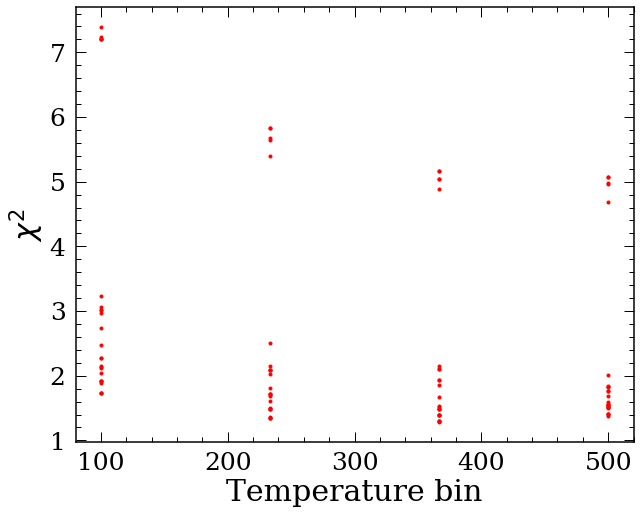

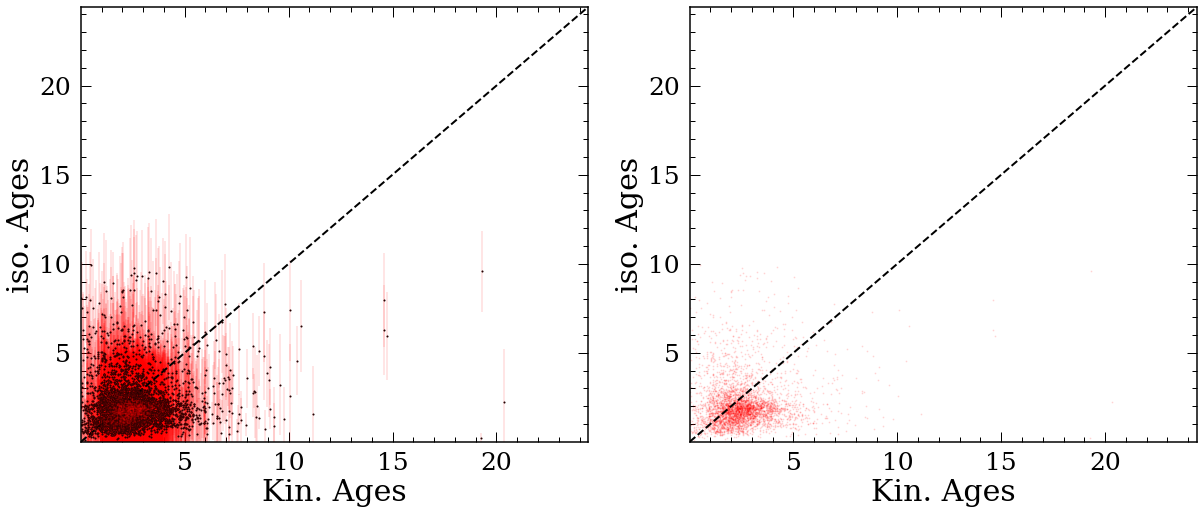

In [61]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a,absg_a)))

#print('absg:',absg_a[0],'logg:',logg_a_s[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
#print([tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])

getkinAges(df_prot_s,['teff_calc','Prot_log','logg_y','abs_G'],
           [366.6666666666667, 2.0, 0.5499999999999999, 0.01])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


df_prot_s.to_pickle('minchisq.pkl')


In [63]:
# compare to real ages
import scipy

protbins=np.linspace(1.,5.,5)
tempbins=np.linspace(100.,500.,4)
absg=np.linspace(0.01,0.05,5)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for l in absg:
            print(float(count)/float(total))
            count=count+1
            getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[i,j,l])
            stat_df=df_prot_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
            if len(stat_df)<1000:
                continue
            stat_df=stat_df.loc[stat_df['iso_age']<10]
            stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
            chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
            chisq.append(chisq_sing/len(stat_df))
            MAD.append(np.median(stat_df['kin_age']-stat_df['iso_age']/
                        np.sqrt(np.power(stat_df['kin_age'],2)+np.power(stat_df['iso_age'],2))))
            tempbins_a.append(i)
            protbins_a.append(j)
            loggbins_a.append(k)
            absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  1%|          | 162/20714 [00:00<00:12, 1610.91it/s]

0.01


100%|██████████| 20714/20714 [00:09<00:00, 2266.64it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  2%|▏         | 456/20714 [00:00<00:08, 2303.40it/s]

0.02


  1%|          | 183/20714 [00:00<00:11, 1826.94it/s]

0.03


  2%|▏         | 479/20714 [00:00<00:09, 2102.12it/s]

0.04


  3%|▎         | 531/20714 [00:00<00:08, 2427.39it/s]

0.05


  1%|          | 253/20714 [00:00<00:08, 2451.31it/s]

0.06


  2%|▏         | 319/20714 [00:00<00:06, 3185.42it/s]

0.07


  3%|▎         | 578/20714 [00:00<00:06, 2885.24it/s]

0.08


  1%|          | 205/20714 [00:00<00:10, 2034.97it/s]

0.09


  1%|          | 219/20714 [00:00<00:09, 2187.75it/s]

0.1


  1%|          | 243/20714 [00:00<00:08, 2425.15it/s]

0.11


  1%|▏         | 260/20714 [00:00<00:07, 2595.98it/s]

0.12


  2%|▏         | 460/20714 [00:00<00:08, 2277.21it/s]

0.13


  2%|▏         | 450/20714 [00:00<00:09, 2172.92it/s]

0.14


  1%|          | 214/20714 [00:00<00:09, 2118.15it/s]

0.15


  3%|▎         | 612/20714 [00:00<00:06, 2920.98it/s]

0.16


  1%|          | 208/20714 [00:00<00:09, 2079.29it/s]

0.17


  1%|▏         | 292/20714 [00:00<00:07, 2914.87it/s]

0.18


  2%|▏         | 340/20714 [00:00<00:06, 3393.14it/s]

0.19


  2%|▏         | 314/20714 [00:00<00:06, 3138.31it/s]

0.2


  1%|▏         | 291/20714 [00:00<00:07, 2904.25it/s]

0.21


  3%|▎         | 608/20714 [00:00<00:06, 3013.12it/s]

0.22


  1%|▏         | 283/20714 [00:00<00:07, 2823.70it/s]

0.23


  2%|▏         | 335/20714 [00:00<00:06, 3277.85it/s]

0.24


  3%|▎         | 604/20714 [00:00<00:06, 2885.22it/s]

0.25


  3%|▎         | 661/20714 [00:00<00:06, 3211.09it/s]

0.26


  1%|▏         | 275/20714 [00:00<00:07, 2742.68it/s]

0.27


  1%|▏         | 281/20714 [00:00<00:07, 2804.95it/s]

0.28


  1%|▏         | 309/20714 [00:00<00:06, 3077.81it/s]

0.29


  1%|▏         | 283/20714 [00:00<00:07, 2825.56it/s]

0.3


  1%|▏         | 303/20714 [00:00<00:06, 3029.82it/s]

0.31


  1%|          | 172/20714 [00:00<00:11, 1717.87it/s]

0.32


  1%|          | 135/20714 [00:00<00:15, 1347.02it/s]

0.33


  2%|▏         | 325/20714 [00:00<00:06, 3244.45it/s]

0.34


  2%|▏         | 323/20714 [00:00<00:06, 3221.58it/s]

0.35


  1%|          | 211/20714 [00:00<00:09, 2107.77it/s]

0.36


  3%|▎         | 716/20714 [00:00<00:05, 3516.56it/s]

0.37


  2%|▏         | 318/20714 [00:00<00:06, 3173.01it/s]

0.38


  3%|▎         | 628/20714 [00:00<00:06, 3123.22it/s]

0.39


  1%|▏         | 285/20714 [00:00<00:07, 2848.46it/s]

0.4


  2%|▏         | 402/20714 [00:00<00:05, 4018.07it/s]

0.41


  4%|▎         | 774/20714 [00:00<00:05, 3854.82it/s]

0.42


  1%|          | 255/20714 [00:00<00:08, 2543.51it/s]

0.43


  2%|▏         | 369/20714 [00:00<00:05, 3682.96it/s]

0.44


  2%|▏         | 327/20714 [00:00<00:06, 3249.70it/s]

0.45


  2%|▏         | 469/20714 [00:00<00:08, 2338.28it/s]

0.46


  4%|▍         | 794/20714 [00:00<00:05, 3942.61it/s]

0.47


  2%|▏         | 319/20714 [00:00<00:06, 3189.36it/s]

0.48


  3%|▎         | 696/20714 [00:00<00:05, 3427.98it/s]

0.49


  1%|▏         | 310/20714 [00:00<00:06, 3095.29it/s]

0.5


  2%|▏         | 320/20714 [00:00<00:06, 3193.36it/s]

0.51


  2%|▏         | 325/20714 [00:00<00:06, 3245.79it/s]

0.52


  2%|▏         | 318/20714 [00:00<00:06, 3174.29it/s]

0.53


  2%|▏         | 327/20714 [00:00<00:06, 3263.08it/s]

0.54


  2%|▏         | 376/20714 [00:00<00:05, 3753.99it/s]

0.55


  2%|▏         | 384/20714 [00:00<00:05, 3835.24it/s]

0.56


  2%|▏         | 368/20714 [00:00<00:05, 3671.56it/s]

0.57


  2%|▏         | 345/20714 [00:00<00:05, 3444.90it/s]

0.58


  2%|▏         | 336/20714 [00:00<00:06, 3355.34it/s]

0.59


  3%|▎         | 677/20714 [00:00<00:05, 3361.53it/s]

0.6


  2%|▏         | 325/20714 [00:00<00:06, 3246.23it/s]

0.61


  1%|▏         | 293/20714 [00:00<00:06, 2926.81it/s]

0.62


  2%|▏         | 373/20714 [00:00<00:05, 3726.12it/s]

0.63


  2%|▏         | 329/20714 [00:00<00:06, 3282.87it/s]

0.64


  1%|          | 161/20714 [00:00<00:12, 1609.73it/s]

0.65


  4%|▎         | 732/20714 [00:00<00:05, 3735.74it/s]

0.66


  2%|▏         | 412/20714 [00:00<00:04, 4110.66it/s]

0.67


  2%|▏         | 369/20714 [00:00<00:05, 3687.60it/s]

0.68


  2%|▏         | 388/20714 [00:00<00:05, 3873.92it/s]

0.69


  2%|▏         | 394/20714 [00:00<00:05, 3929.74it/s]

0.7


  2%|▏         | 378/20714 [00:00<00:05, 3779.89it/s]

0.71


  2%|▏         | 377/20714 [00:00<00:05, 3768.49it/s]

0.72


  1%|▏         | 300/20714 [00:00<00:06, 2997.84it/s]

0.73


  2%|▏         | 391/20714 [00:00<00:05, 3902.26it/s]

0.74


  2%|▏         | 399/20714 [00:00<00:05, 3988.17it/s]

0.75


  2%|▏         | 405/20714 [00:00<00:05, 4049.23it/s]

0.76


  2%|▏         | 404/20714 [00:00<00:05, 4034.92it/s]

0.77


  4%|▍         | 805/20714 [00:00<00:04, 4021.39it/s]

0.78


  0%|          | 97/20714 [00:00<00:21, 963.53it/s]

0.79


  2%|▏         | 381/20714 [00:00<00:05, 3806.15it/s]

0.8


  2%|▏         | 403/20714 [00:00<00:05, 4015.46it/s]

0.81


  4%|▍         | 806/20714 [00:00<00:04, 4001.37it/s]

0.82


  4%|▎         | 745/20714 [00:00<00:05, 3697.33it/s]

0.83


  4%|▎         | 766/20714 [00:00<00:05, 3820.47it/s]

0.84


  4%|▎         | 758/20714 [00:00<00:05, 3757.05it/s]

0.85


  2%|▏         | 388/20714 [00:00<00:05, 3874.89it/s]

0.86


  2%|▏         | 387/20714 [00:00<00:05, 3869.03it/s]

0.87


  2%|▏         | 389/20714 [00:00<00:05, 3884.72it/s]

0.88


  4%|▎         | 772/20714 [00:00<00:05, 3841.54it/s]

0.89


  4%|▎         | 771/20714 [00:00<00:05, 3852.23it/s]

0.9


  4%|▍         | 816/20714 [00:00<00:04, 4072.07it/s]

0.91


  2%|▏         | 408/20714 [00:00<00:04, 4079.23it/s]

0.92


  2%|▏         | 401/20714 [00:00<00:05, 4002.00it/s]

0.93


  4%|▎         | 765/20714 [00:00<00:05, 3798.55it/s]

0.94


  2%|▏         | 381/20714 [00:00<00:05, 3807.60it/s]

0.95


  2%|▏         | 405/20714 [00:00<00:05, 4046.89it/s]

0.96


  2%|▏         | 406/20714 [00:00<00:05, 4054.85it/s]

0.97


  2%|▏         | 386/20714 [00:00<00:05, 3856.84it/s]

0.98


  2%|▏         | 392/20714 [00:00<00:05, 3916.35it/s]

0.99


  4%|▎         | 769/20714 [00:00<00:05, 3813.11it/s]

1.0


100%|██████████| 20714/20714 [00:05<00:00, 3915.95it/s]


  3%|▎         | 689/20714 [00:00<00:06, 3269.32it/s]

absg: 0.01 prot: 2.0 temp: 366.6666666666667 1.2837296156285751
[366.6666666666667, 2.0, 0.01]


100%|██████████| 20714/20714 [00:05<00:00, 3779.23it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


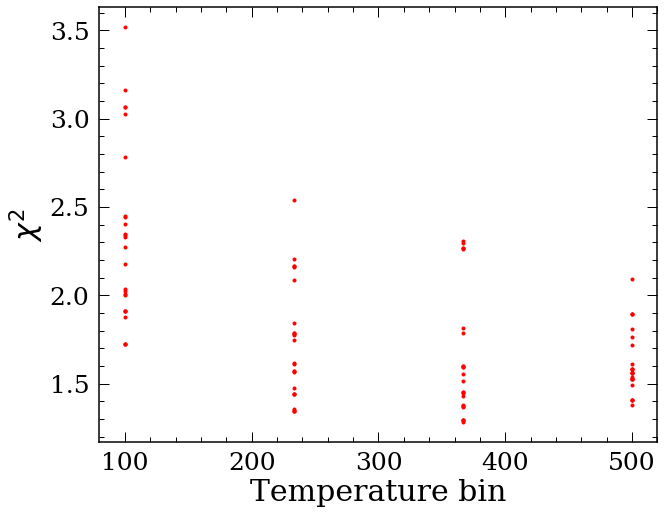

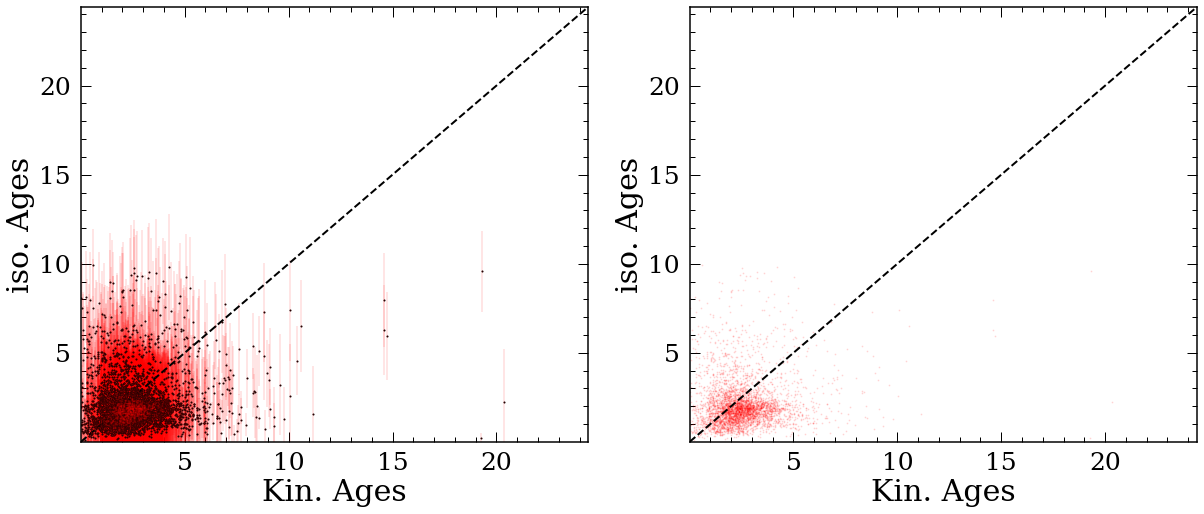

In [65]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,absg_a)))

print('absg:',absg_a[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])

getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


df_prot_s.to_pickle('minchisq.pkl')



## average ages (real chisq)

In [ ]:
# get average ages in a bin
import scipy

tempbins=[400.,500.,600.,700.,800,900,1000]
protbins=[0.3,0.4,0.5,0.6,0.7]
loggbins=[0.1,0.2,0.5,0.7,0.8]
chisq=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            print(float(count)/float(total))
            count=count+1
            getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[i,j,k])
            df_prot_s=df_prot_s.dropna(subset=['kin_age','iso_age_ave','iso_age_ave_err'])
            stat_df=df_prot_s.loc[df_prot_s['iso_age']<10]
            chisq_single=sum(np.power(stat_df['kin_age']-stat_df['iso_age_ave'],2.)/stat_df['iso_age_ave_err'])
            chisq.append(chisq_single)
            tempbins_a.append(i)
            protbins_a.append(j)
            loggbins_a.append(k)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

100%|██████████| 20714/20714 [00:06<00:00, 3231.08it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


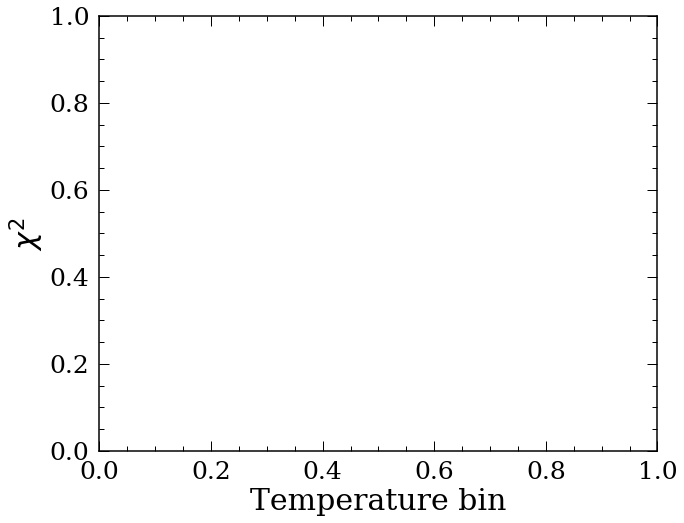

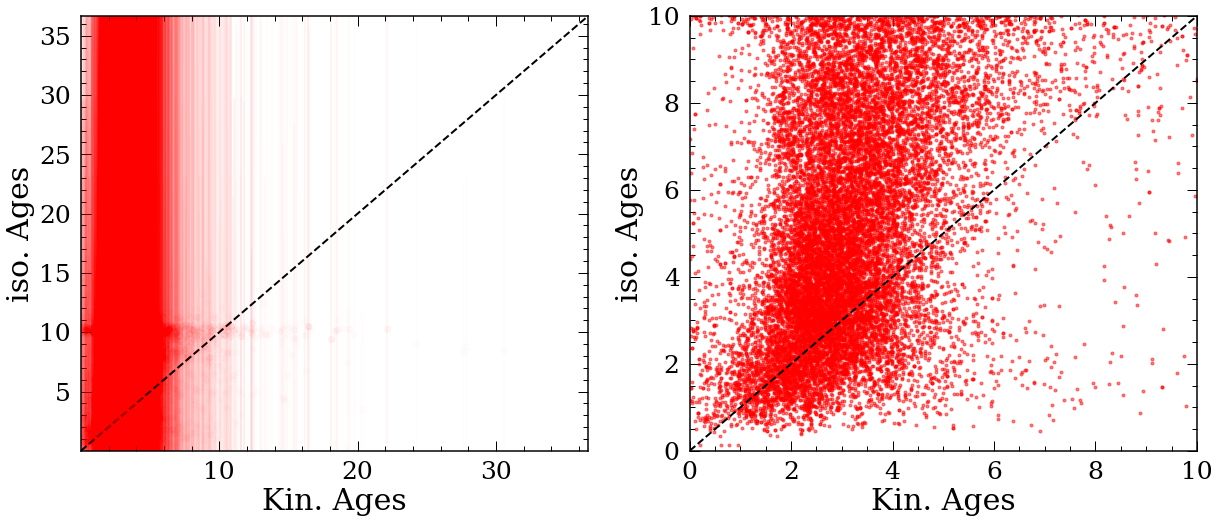

In [66]:
plt.figure(figsize=(10,8))
#plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

#chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a)))

#print(logg_a_s[0],rotbin_a_s[0],tempbin_a_s[0],chisq_s[0])

#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[100,0.4,0.5])
getAveAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[366.6666666666667, 2.0, 0.01])


df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_prot_s['kin_age'], df_prot_s['iso_age_ave'],yerr=df_prot_s['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_prot_s['iso_age_ave']),min(df_prot_s['kin_age']))
maxage=max(max(df_prot_s['iso_age_ave']),max(df_prot_s['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_prot_s['kin_age'], df_prot_s['iso_age_ave'],'r.',alpha=0.5)
minage=min(min(df_prot_s['iso_age_ave']),min(df_prot_s['kin_age']))
maxage=max(max(df_prot_s['iso_age_ave']),max(df_prot_s['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

df_prot_s.to_pickle('minchisq.pkl')

# For Rvars

## real ages (real chisq)

In [22]:
np.linspace(0.3,10.,5)

array([ 0.3  ,  2.725,  5.15 ,  7.575, 10.   ])

In [23]:
# compare to real ages
import scipy

protbins=np.linspace(2,8,5)
loggbins=np.linspace(0.17,0.5,5)
tempbins=np.linspace(200.,400.,4)
absg=[0.01]

df_rvar_s['iso_age_err']=np.sqrt(df_rvar_s['iso_age_err1']**2.+df_rvar_s['iso_age_err2']**2.)

chisq=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            for l in absg:
                print(float(count)/float(total))
                count=count+1
                getkinAges(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],[i,j,k,l])
                stat_df=df_rvar_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
                if len(stat_df)<1000:
                    continue
                stat_df=stat_df.loc[stat_df['iso_age']<10]
                stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
                chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
                chisq.append(chisq_sing/len(stat_df))
                
                tempbins_a.append(i)
                protbins_a.append(j)
                loggbins_a.append(k)
                absg_a.append(l)


  0%|          | 44/84824 [00:00<03:17, 428.53it/s]

0.01


100%|██████████| 84824/84824 [01:52<00:00, 752.24it/s] 
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 79/84824 [00:00<01:48, 782.60it/s]

0.02


  0%|          | 212/84824 [00:00<01:20, 1053.88it/s]

0.03


  0%|          | 90/84824 [00:00<01:34, 896.07it/s]

0.04


  0%|          | 101/84824 [00:00<01:24, 1007.32it/s]

0.05


  0%|          | 97/84824 [00:00<01:27, 963.74it/s]

0.06


  0%|          | 102/84824 [00:00<01:23, 1011.53it/s]

0.07


  0%|          | 106/84824 [00:00<01:20, 1057.93it/s]

0.08


  0%|          | 97/84824 [00:00<01:27, 968.29it/s]

0.09


  0%|          | 103/84824 [00:00<01:22, 1024.74it/s]

0.1


  0%|          | 100/84824 [00:00<01:25, 990.15it/s]

0.11


  0%|          | 189/84824 [00:00<01:31, 922.60it/s]

0.12


  0%|          | 94/84824 [00:00<01:30, 932.09it/s]

0.13


  0%|          | 96/84824 [00:00<01:28, 954.26it/s]

0.14


  0%|          | 88/84824 [00:00<01:36, 876.49it/s]

0.15


  0%|          | 66/84824 [00:00<02:08, 657.25it/s]

0.16


  0%|          | 98/84824 [00:00<01:26, 976.95it/s]

0.17


  0%|          | 99/84824 [00:00<01:25, 988.79it/s]

0.18


  0%|          | 189/84824 [00:00<01:30, 939.88it/s]

0.19


  0%|          | 162/84824 [00:00<01:48, 782.10it/s]

0.2


  0%|          | 103/84824 [00:00<01:22, 1022.88it/s]

0.21


  0%|          | 96/84824 [00:00<01:29, 950.92it/s]

0.22


  0%|          | 102/84824 [00:00<01:23, 1015.09it/s]

0.23


  0%|          | 80/84824 [00:00<01:47, 789.92it/s]

0.24


  0%|          | 55/84824 [00:00<02:36, 541.97it/s]

0.25


  0%|          | 93/84824 [00:00<01:31, 925.91it/s]

0.26


  0%|          | 94/84824 [00:00<01:30, 932.66it/s]

0.27


  0%|          | 198/84824 [00:00<01:25, 987.83it/s]

0.28


  0%|          | 98/84824 [00:00<01:26, 978.58it/s]

0.29


  0%|          | 65/84824 [00:00<02:10, 649.96it/s]

0.3


  0%|          | 195/84824 [00:00<01:27, 968.56it/s]

0.31


  0%|          | 68/84824 [00:00<02:05, 677.75it/s]

0.32


  0%|          | 187/84824 [00:00<01:30, 930.29it/s]

0.33


  0%|          | 82/84824 [00:00<01:44, 813.93it/s]

0.34


  0%|          | 198/84824 [00:00<01:26, 983.16it/s]

0.35


  0%|          | 179/84824 [00:00<01:34, 892.11it/s]

0.36


  0%|          | 62/84824 [00:00<02:21, 600.91it/s]

0.37


  0%|          | 94/84824 [00:00<01:30, 931.81it/s]

0.38


  0%|          | 102/84824 [00:00<01:23, 1011.61it/s]

0.39


  0%|          | 103/84824 [00:00<01:22, 1027.52it/s]

0.4


  0%|          | 95/84824 [00:00<01:29, 944.29it/s]

0.41


  0%|          | 100/84824 [00:00<01:25, 992.63it/s]

0.42


  0%|          | 106/84824 [00:00<01:20, 1057.45it/s]

0.43


  0%|          | 101/84824 [00:00<01:24, 1007.81it/s]

0.44


  0%|          | 105/84824 [00:00<01:21, 1042.32it/s]

0.45


  0%|          | 210/84824 [00:00<01:21, 1039.56it/s]

0.46


  0%|          | 105/84824 [00:00<01:21, 1045.17it/s]

0.47


  0%|          | 76/84824 [00:00<01:51, 759.74it/s]

0.48


  0%|          | 107/84824 [00:00<01:19, 1060.52it/s]

0.49


  0%|          | 204/84824 [00:00<01:23, 1009.56it/s]

0.5


  0%|          | 88/84824 [00:00<01:36, 875.64it/s]

0.51


  0%|          | 103/84824 [00:00<01:22, 1023.95it/s]

0.52


  0%|          | 99/84824 [00:00<01:25, 985.59it/s]

0.53


  0%|          | 105/84824 [00:00<01:20, 1048.94it/s]

0.54


  0%|          | 212/84824 [00:00<01:20, 1056.87it/s]

0.55


  0%|          | 203/84824 [00:00<01:23, 1007.84it/s]

0.56


  0%|          | 78/84824 [00:00<01:49, 773.89it/s]

0.57


  0%|          | 43/84824 [00:00<03:21, 420.38it/s]

0.58


  0%|          | 101/84824 [00:00<01:24, 1001.08it/s]

0.59


  0%|          | 200/84824 [00:00<01:24, 999.78it/s] 

0.6


  0%|          | 95/84824 [00:00<01:29, 944.79it/s]

0.61


  0%|          | 65/84824 [00:00<02:11, 646.01it/s]

0.62


  0%|          | 81/84824 [00:00<01:45, 806.41it/s]

0.63


  0%|          | 73/84824 [00:00<01:56, 725.43it/s]

0.64


  0%|          | 74/84824 [00:00<01:54, 739.59it/s]

0.65


  0%|          | 113/84824 [00:00<01:15, 1122.22it/s]

0.66


  0%|          | 98/84824 [00:00<01:26, 978.83it/s]

0.67


  0%|          | 104/84824 [00:00<01:21, 1038.86it/s]

0.68


  0%|          | 99/84824 [00:00<01:25, 987.61it/s]

0.69


  0%|          | 116/84824 [00:00<01:13, 1158.47it/s]

0.7


  0%|          | 118/84824 [00:00<01:12, 1169.88it/s]

0.71


  0%|          | 106/84824 [00:00<01:20, 1048.68it/s]

0.72


  0%|          | 114/84824 [00:00<01:14, 1139.23it/s]

0.73


  0%|          | 104/84824 [00:00<01:21, 1038.55it/s]

0.74


  0%|          | 106/84824 [00:00<01:20, 1056.66it/s]

0.75


  0%|          | 238/84824 [00:00<01:11, 1189.07it/s]

0.76


  0%|          | 209/84824 [00:00<01:21, 1037.09it/s]

0.77


  0%|          | 42/84824 [00:00<03:24, 415.07it/s]

0.78


  0%|          | 229/84824 [00:00<01:14, 1135.94it/s]

0.79


  0%|          | 115/84824 [00:00<01:13, 1146.22it/s]

0.8


  0%|          | 118/84824 [00:00<01:12, 1172.14it/s]

0.81


  0%|          | 117/84824 [00:00<01:12, 1161.62it/s]

0.82


  0%|          | 111/84824 [00:00<01:16, 1106.04it/s]

0.83


  0%|          | 225/84824 [00:00<01:15, 1116.50it/s]

0.84


  0%|          | 207/84824 [00:00<01:21, 1036.90it/s]

0.85


  0%|          | 113/84824 [00:00<01:15, 1119.25it/s]

0.86


  0%|          | 112/84824 [00:00<01:15, 1115.10it/s]

0.87


  0%|          | 80/84824 [00:00<01:46, 796.92it/s]

0.88


  0%|          | 110/84824 [00:00<01:17, 1091.11it/s]

0.89


  0%|          | 113/84824 [00:00<01:15, 1121.41it/s]

0.9


  0%|          | 115/84824 [00:00<01:14, 1139.44it/s]

0.91


  0%|          | 112/84824 [00:00<01:15, 1118.58it/s]

0.92


  0%|          | 100/84824 [00:00<01:25, 992.61it/s]

0.93


  0%|          | 113/84824 [00:00<01:15, 1127.62it/s]

0.94


  0%|          | 228/84824 [00:00<01:14, 1137.16it/s]

0.95


  0%|          | 114/84824 [00:00<01:14, 1134.51it/s]

0.96


  0%|          | 104/84824 [00:00<01:21, 1033.93it/s]

0.97


  0%|          | 85/84824 [00:00<01:40, 846.71it/s]

0.98


  0%|          | 118/84824 [00:00<01:11, 1178.21it/s]

0.99


  0%|          | 108/84824 [00:00<01:19, 1071.82it/s]

1.0


100%|██████████| 84824/84824 [01:24<00:00, 998.27it/s] 


100%|██████████| 84824/84824 [00:54<00:00, 1552.66it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'iso. Ages')

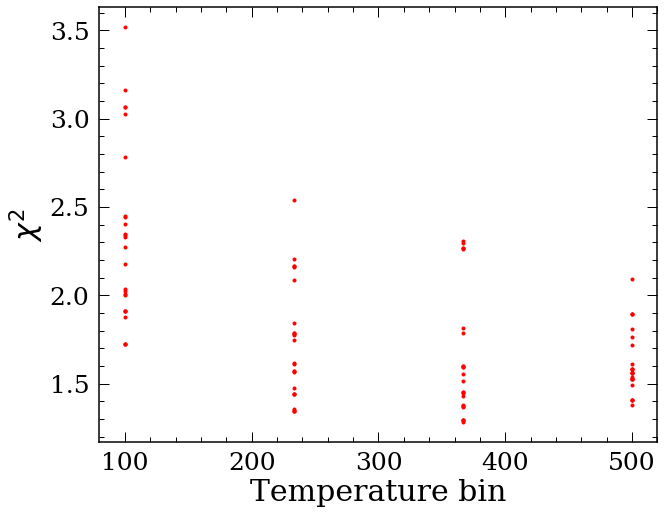

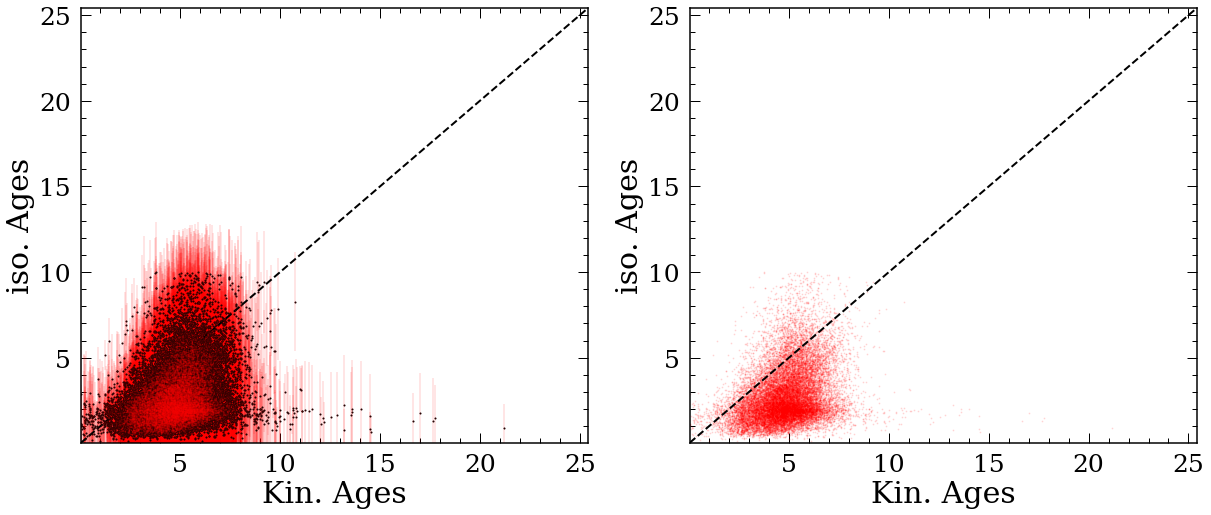

In [68]:
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a)))

#print('absg:',absg_a[0],'logg:',logg_a_s[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
#print([tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])

getkinAges(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [266.6666666666667, 5.0, 0.4175, 0.01])

df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
             yerr=df_rvar_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
         'ko',alpha=1,markersize=1)
minage=min(min(df_rvar_s_plot['iso_age']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age']),max(df_rvar_s_plot['kin_age']))

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

df_rvar_s.to_pickle('minchisq_rvar.pkl')



In [28]:
df_rvar_s.loc[df_rvar_s['KID']==11075611]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
73535,11075611,0.539,0.013,-0.013,3761.3,77.3,-77.3,4.686,0.013,-0.013,...,11075611,4.530539,4689.908028,3504.631839,3.671164,4.917,-9.770699,8.817705,9.117511,4.346705


In [29]:
df_rvar_s.loc[df_rvar_s['KID']==12456401]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
84040,12456401,0.526,0.012,-0.013,3809.6,81.2,-71.5,4.704,0.012,-0.012,...,12456401,4.385001,4237.663746,3679.311078,3.627126,4.826,7.88599,8.63656,9.347304,2.313152


In [77]:
getAveAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],
           [266.6666666666667, 5.0, 0.01])



100%|██████████| 84824/84824 [01:11<00:00, 1194.37it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


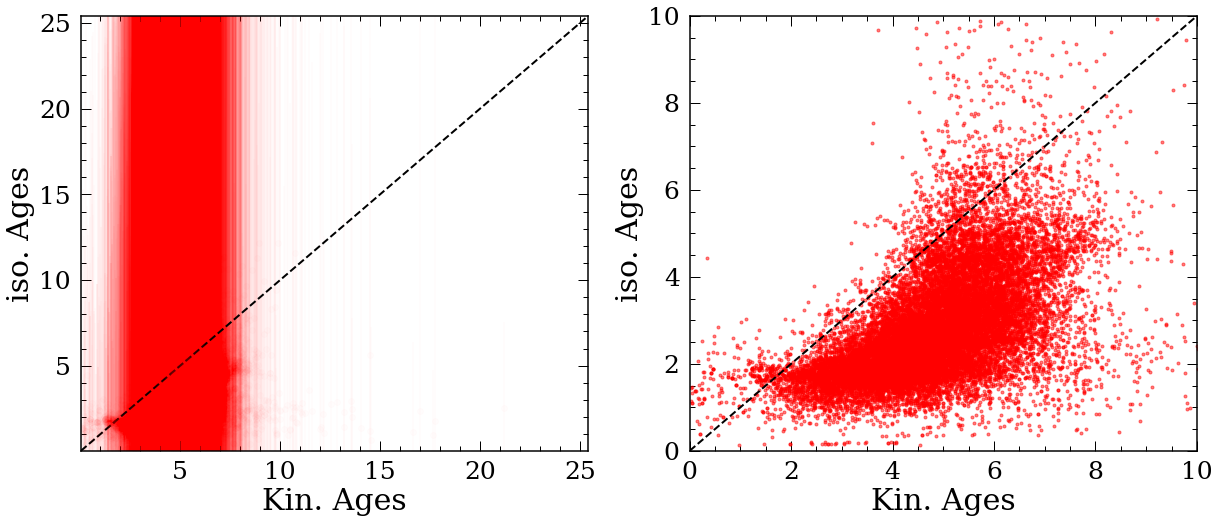

In [79]:
df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],yerr=df_rvar_s_plot['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],'r.',alpha=0.5)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.savefig('wologg.png')
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [39]:

    

ages=getkinAges_err(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]],sampsize=50) 



100%|██████████| 84824/84824 [01:20<00:00, 1051.85it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 84824/84824 [01:25<00:00, 986.87it/s] 


(array([25., 14.,  5.,  1.,  0.,  0.,  1.,  1.,  2.,  1.]),
 array([5.54410196, 5.73763689, 5.93117181, 6.12470674, 6.31824166,
        6.51177659, 6.70531151, 6.89884643, 7.09238136, 7.28591628,
        7.47945121]),
 <a list of 10 Patch objects>)

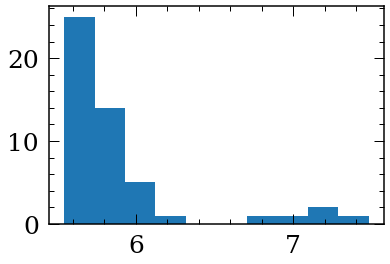

In [81]:
plt.hist(ages[10,:])

In [3]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age,iso_age_ave,iso_age_ave_err,kin_age_err,source_id
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,4.335097,4.500,-33.411547,5.517761,7.433176,6.050929,6.389688,759.97,0.671505,2.050232e+18
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,3.505987,4.574,-4.214296,6.159685,8.361459,5.329557,6.602250,496.15,0.834650,2.050232e+18
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,3.252893,4.547,36.144482,5.998116,7.047929,5.374382,9.921913,443.54,1.041803,2.050236e+18
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,3.464520,4.560,26.448217,6.161795,8.510323,4.650196,6.560067,469.66,1.334890,2.050233e+18
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,4.180735,4.615,-0.966857,6.411296,8.748257,2.800943,7.478731,388.49,0.448719,2.050232e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84819,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,3.449165,4.500,18.829108,6.176964,6.371766,3.519965,15.195308,59.82,1.223089,2.139326e+18
84820,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,3.255194,4.571,-10.180756,4.676241,4.325101,3.603349,16.875361,64.17,0.613842,2.139336e+18
84821,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,3.309001,4.423,4.480242,4.376738,3.396115,6.606545,4.493451,475.13,0.684779,2.139336e+18
84822,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,4.028109,4.579,-0.407244,5.892401,8.148325,6.852331,9.580305,574.14,0.544911,2.139342e+18


In [56]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [50]:
age_err=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_rvar_s))] 

In [51]:
df_rvar_s['kin_age_err']=age_err

In [55]:
df_rvar_s=pd.merge(df_rvar_s,pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')[['KID','source_id']],left_on='KID',right_on='KID',how='inner')

In [54]:
df_rvar_p

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,iso_gof,TAMS\\,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,1.0,16.1\\,757450,3.169943,21632.027626,5313.795979,4.335097,4.500,-33.411547,5.517761
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,1.0,23.06\\,892718,4.666500,3206.175566,5058.354128,3.505987,4.574,-4.214296,6.159685
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,1.0,24.12\\,892772,4.925885,1790.165901,4898.417653,3.252893,4.547,36.144482,5.998116
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,1.0,23.42\\,892832,4.717011,2914.205194,5059.657160,3.464520,4.560,26.448217,6.161795
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,1.0,27.05\\,892834,3.633430,15161.266923,4856.095860,4.180735,4.615,-0.966857,6.411296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84820,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,1.0,27.52\\,12935144,4.581993,2812.966704,4623.859643,3.449165,4.500,18.829108,6.176964
84821,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,1.0,15.52\\,12983952,4.896960,1799.672842,5347.731327,3.255194,4.571,-10.180756,4.676241
84822,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,1.0,7.49\\,12984012,4.455203,2037.048340,6043.922841,3.309001,4.423,4.480242,4.376738
84823,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,1.0,22.31\\,12984138,4.025700,10668.635368,5044.668752,4.028109,4.579,-0.407244,5.892401


In [83]:
list(pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl').columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g

In [2]:
df=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

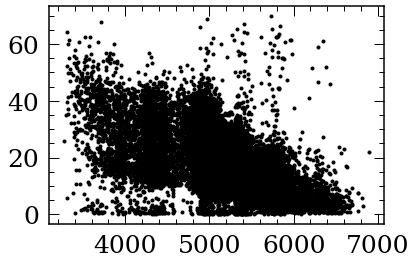

In [92]:
plt.plot(df['teff_val'],df['Prot'],'k.')

In [3]:
def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX



In [ ]:
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)


In [12]:
np.shape(px_s)

(88561, 10000)

In [10]:
testing=10000
vts=np.zeros((len(df),testing))
vbs=np.zeros((len(df),testing))
for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,1)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,1)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,1)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,1)
    vts[:,i],vbs[:,i]=getVs(px_s[:,0],pmra_s[:,0],pmdec_s[:,0],ra_s[:,0],dec_s[:,0])
    
    

100%|██████████| 10000/10000 [5:13:36<00:00,  1.88s/it] 


In [17]:
vt_err=np.zeros(len(df))
vb_err=np.zeros(len(df))

for i in trange(len(df)):
    vt_err[i]=np.std(vts[i,:])
    vb_err[i]=np.std(vbs[i,:])

100%|██████████| 88561/88561 [02:02<00:00, 725.52it/s] 


array([0.77786295, 0.77786295, 0.77786295, ..., 0.77786295, 0.77786295,
       0.77786295])

In [18]:
df['v_t_err']=vt_err
df['v_b_err']=vb_err


In [4]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

In [ ]:
testing=10000
absg_err=np.zeros((len(df),testing))

for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,0])


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [ ]:
absg_err_err=np.zeros(len(df))
for i in trange(len(df)):
    absg_err_err[i]=np.std(absg_err[i,:])

In [ ]:
df['abs_G_err']=absg_err_err

In [20]:
#add_col=['v_t_err','v_b_err','abs_G_err']
add_col=['v_t_err','v_b_err']
columns_non=[i for i in df_rvar_s.columns if i not in add_col]
len(columns_non)

46

In [21]:
df_rvar_s=pd.merge(df_rvar_s[columns_non],df[np.append(['KID'],add_col)],left_on='KID',right_on='KID',how='inner')

In [22]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,v_b,abs_G,iso_age_err,kin_age,iso_age_ave,iso_age_ave_err,kin_age_err,source_id,v_t_err,v_b_err
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,-33.411547,5.517761,7.433176,6.050929,6.389688,759.97,0.671505,2.050232e+18,0.777863,0.768051
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,-4.214296,6.159685,8.361459,5.329557,6.602250,496.15,0.834650,2.050232e+18,1.699234,0.333401
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,36.144482,5.998116,7.047929,5.374382,9.921913,443.54,1.041803,2.050236e+18,2.247376,1.886702
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,26.448217,6.161795,8.510323,4.650196,6.560067,469.66,1.334890,2.050233e+18,2.409767,0.730871
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,-0.966857,6.411296,8.748257,2.800943,7.478731,388.49,0.448719,2.050232e+18,0.275913,0.129022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84819,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,18.829108,6.176964,6.371766,3.519965,15.195308,59.82,1.223089,2.139326e+18,1.477193,0.368733
84820,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,-10.180756,4.676241,4.325101,3.603349,16.875361,64.17,0.613842,2.139336e+18,0.732005,0.394648
84821,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,4.480242,4.376738,3.396115,6.606545,4.493451,475.13,0.684779,2.139336e+18,2.733565,0.386915
84822,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,-0.407244,5.892401,8.148325,6.852331,9.580305,574.14,0.544911,2.139342e+18,0.285433,0.314944


In [23]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [ ]:
df['teff_calc']

In [ ]:
df['teff_val_err']=(df['teff_percentile_upper']-df['teff_percentile_lower'])/2.
df['teff_val_err']


In [ ]:
df_rvar_s=pd.merge(df_rvar_s,df[np.append(['KID'],['Prot_err'])],left_on='KID',right_on='KID',how='inner')



In [ ]:
df_rvar_s